**Import dataset from kaggle**

*   Requires one to upload a kaggle.json file from their kaggle account.

*   The files are then unzipped into a folder finalyearproject



In [ ]:
!pip install -q kaggle
import os


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emmillyimmaculate","key":"16e7dea75e82f70302fdd9675c67bf72"}'}

In [ ]:

os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
%cd /content/
! chmod 600 /content/kaggle.json
!kaggle datasets download -d emmillyimmaculate/poultry-cocci
! unzip poultry-cocci.zip

/content
 88% 106M/120M [00:04<00:00, 25.0MB/s] 
100% 120M/120M [00:04<00:00, 29.6MB/s]
Archive:  poultry-cocci.zip
  inflating: finalyearproject2/Train/cocci.0.jpg  
  inflating: finalyearproject2/Train/cocci.1.jpg  
  inflating: finalyearproject2/Train/cocci.10.jpg  
  inflating: finalyearproject2/Train/cocci.100.jpg  
  inflating: finalyearproject2/Train/cocci.1000.jpg  
  inflating: finalyearproject2/Train/cocci.1001.jpg  
  inflating: finalyearproject2/Train/cocci.1002.jpg  
  inflating: finalyearproject2/Train/cocci.1003.jpg  
  inflating: finalyearproject2/Train/cocci.1004.jpg  
  inflating: finalyearproject2/Train/cocci.1005.jpg  
  inflating: finalyearproject2/Train/cocci.1006.jpg  
  inflating: finalyearproject2/Train/cocci.1007.jpg  
  inflating: finalyearproject2/Train/cocci.1008.jpg  
  inflating: finalyearproject2/Train/cocci.1009.jpg  
  inflating: finalyearproject2/Train/cocci.101.jpg  
  inflating: finalyearproject2/Train/cocci.1010.jpg  
  inflating: finalyearproject2

**Import needed modules**

In [ ]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model


In [ ]:
# import the csv data 
df = pd.read_csv('finalyearproject2/train_dat.csv')
df.head()

,images,label
0,cocci.1866.jpg,Coccidiosis
1,cocci.171.jpg,Coccidiosis
2,healthy.1748.jpg,Healthy
3,healthy.1156.jpg,Healthy
4,healthy.1215.jpg,Healthy


In [ ]:
df.count()

images    4880
label     4880
dtype: int64

In [ ]:
#change column labels to filepath and labels
df.columns=['filepaths', 'labels' ]
df.head()

,filepaths,labels
0,cocci.1866.jpg,Coccidiosis
1,cocci.171.jpg,Coccidiosis
2,healthy.1748.jpg,Healthy
3,healthy.1156.jpg,Healthy
4,healthy.1215.jpg,Healthy


In [ ]:
# change filepaths to have the whole path to the each image
original_dir='/content/finalyearproject2/Train'

df['filepaths']=df['filepaths'].apply(lambda x: os.path.join(original_dir,x))
df.head()

,filepaths,labels
0,/content/finalyearproject2/Train/cocci.1866.jpg,Coccidiosis
1,/content/finalyearproject2/Train/cocci.171.jpg,Coccidiosis
2,/content/finalyearproject2/Train/healthy.1748.jpg,Healthy
3,/content/finalyearproject2/Train/healthy.1156.jpg,Healthy
4,/content/finalyearproject2/Train/healthy.1215.jpg,Healthy


In [ ]:
df_labels=df['labels']
df_labels.head()

0    Coccidiosis
1    Coccidiosis
2        Healthy
3        Healthy
4        Healthy
Name: labels, dtype: object

**Creating train,validation and test datasets.**

In [ ]:
train_split=.7
vsplit=0.2
dsplit =vsplit/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df_labels)

In [ ]:
unique, counts = np.unique(train_df['labels'], return_counts=True)
result = np.column_stack((unique, counts)) 
print (result)

[['Coccidiosis' 1981]
 ['Healthy' 1923]]


In [ ]:
strat=dummy_df['labels']
test_df, valid_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)


In [ ]:
unique, counts = np.unique(test_df['labels'], return_counts=True)
result = np.column_stack((unique, counts)) 
print (result)

[['Coccidiosis' 330]
 ['Healthy' 320]]


In [ ]:
unique, counts = np.unique(valid_df['labels'], return_counts=True)
result = np.column_stack((unique, counts)) 
print (result)

[['Coccidiosis' 165]
 ['Healthy' 161]]




```
# This is formatted as code
```

**Balance the train dataset with 1900**

In [ ]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('O Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [ ]:
max_samples=1900
min_samples=0
column = 'labels'
train_df=trim(train_df, max_samples, min_samples, column)
img_size=(224,224)
working_dir=r'./'

O Number of classes in dataframe:  2
[1900, 1900]




```
# This is formatted as code
```

**Data Augumentation**
We created imagedatagenerator objects 
We used the ImageDataGenerator to apply rotations,flipping zooming,shifting height to prevent overfitting of the model.

In [ ]:
batch_size=20 # 
train_generator = ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,height_shift_range=.2, zoom_range=.5)
test_validate_generator = ImageDataGenerator()

train_gen=train_generator.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen=test_validate_generator.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

length=len(test_df)
test_batch_size=50
test_steps=int(length/test_batch_size)
test_gen=test_validate_generator.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)


# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
print ('{0:^25s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^25s}{str(index):^12s}')

Found 3244 validated image filenames belonging to 2 classes.
Found 280 validated image filenames belonging to 2 classes.
Found 553 validated image filenames belonging to 2 classes.
test batch size:  50   test steps:  13  number of classes :  2
       class name        class index 
       Coccidiosis            0      
         Healthy              1      


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 556 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 46 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 97 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Show training images

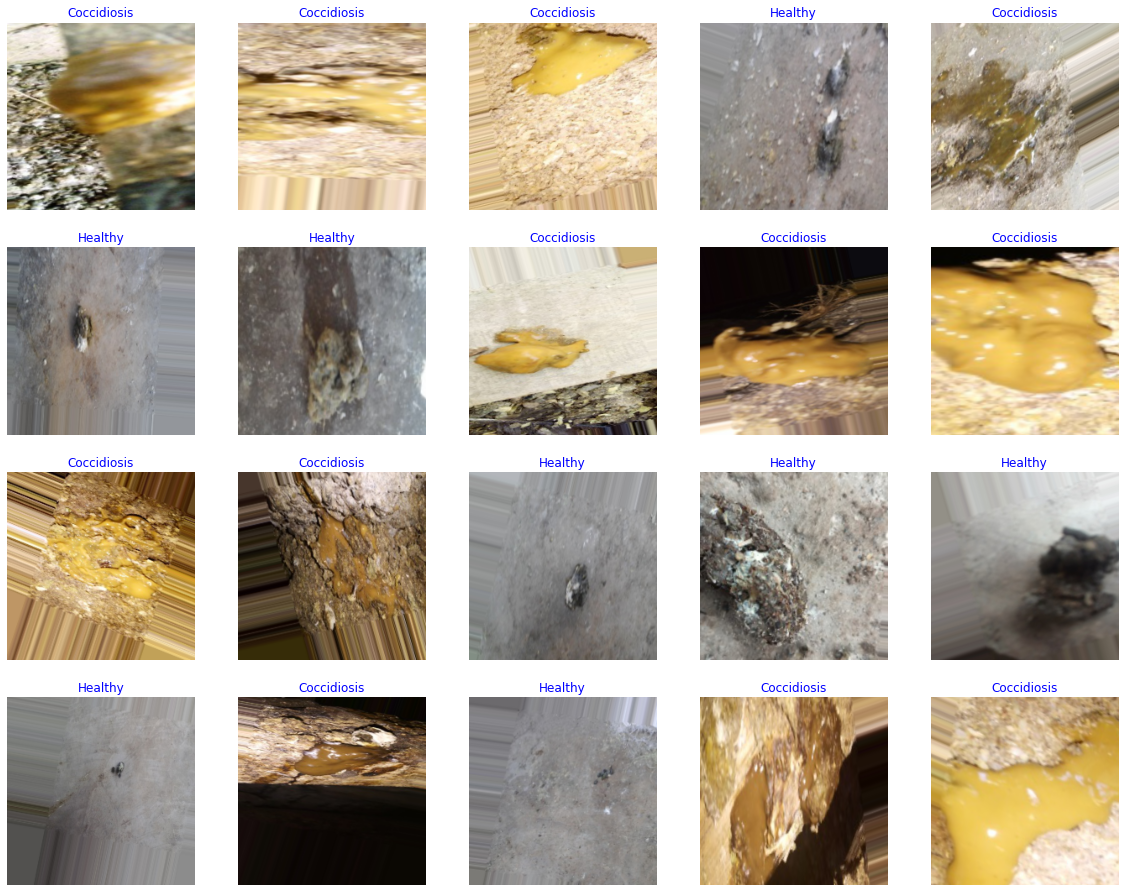

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [ ]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB6'
base_model=tf.keras.applications.efficientnet.EfficientNetB6(include_top=False,weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
base_model.summary()

165249024/165234480 [==============================] - 5s 0us/step
Model: "efficientnetb6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (Ze

In [ ]:

layer =BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(layer)
layer = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(layer)
layer = Dropout(rate=.3, seed=123)(layer)
layer = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(layer)
layer = Dropout(rate=.45, seed=123)(layer)        
output = Dense(class_count, activation='sigmoid')(layer)
model = Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

train

In [ ]:
history=model.fit(x=train_gen,  epochs=14, verbose=1,   validation_data=valid_gen,
           validation_steps=None,  shuffle=False,  initial_epoch=0    )

Epoch 1/40
163/163 [==============================] - 188s 912ms/step - loss: 19.3835 - accuracy: 0.9319 - val_loss: 12.0789 - val_accuracy: 1.0000
Epoch 2/40
163/163 [==============================] - 144s 884ms/step - loss: 8.4813 - accuracy: 0.9744 - val_loss: 5.7540 - val_accuracy: 1.0000
Epoch 3/40
163/163 [==============================] - 145s 886ms/step - loss: 4.2263 - accuracy: 0.9806 - val_loss: 2.9385 - val_accuracy: 1.0000
Epoch 4/40
163/163 [==============================] - 144s 883ms/step - loss: 2.3123 - accuracy: 0.9867 - val_loss: 1.6987 - val_accuracy: 1.0000
Epoch 5/40
163/163 [==============================] - 145s 887ms/step - loss: 1.3614 - accuracy: 0.9923 - val_loss: 1.0302 - val_accuracy: 0.9964
Epoch 6/40
163/163 [==============================] - 144s 885ms/step - loss: 0.8753 - accuracy: 0.9914 - val_loss: 0.6776 - val_accuracy: 1.0000
Epoch 7/40
163/163 [==============================] - 144s 879ms/step - loss: 0.6000 - accuracy: 0.9957 - val_loss: 0.4719

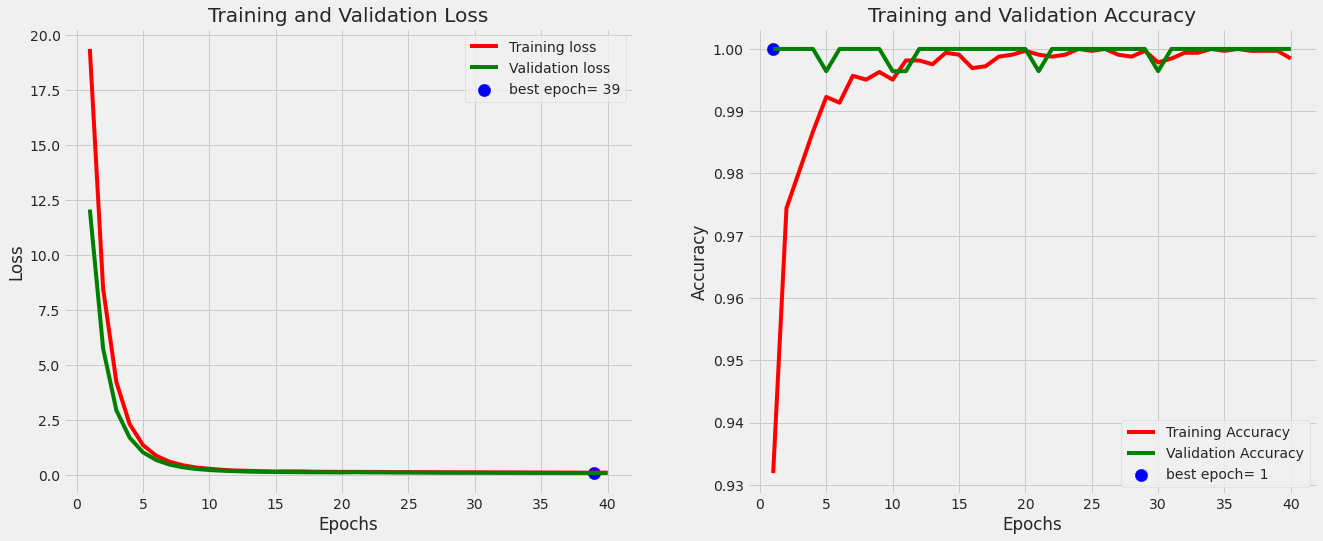

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

In [ ]:
y_pred= []
y_true=test_gen.labels
errors=0
preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
tests=len(preds)
for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
        y_pred.append(pred_index)
acc=( 1-errors/tests) * 100
print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
ypred=np.array(y_pred)
ytrue=np.array(y_true)
cm = confusion_matrix(ytrue, ypred )
# plot the confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)

 3/13 [=====>........................] - ETA: 2s

In [ ]:
subject='chickens' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 

In [ ]:
# from keras.preprocessing import image

# image1='/content/poop.jpeg'
# img_width, img_height = 224, 224
# img = image.load_img(image1, target_size = (img_width, img_height))
# img = image.img_to_array(img)
# img = np.expand_dims(img, axis = 0)

# model.predict(image[0])

In [ ]:
model_lite = tf.keras.models.load_model('./chickens_100.0.h5')


In [ ]:
convertor = tf.lite.TFLiteConverter.from_keras_model(model_lite)

In [ ]:
tflite_model = convertor.convert()

In [ ]:
open('./coccis2.tflite',"wb").write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path="coccis2.tflite")
interpreter.resize_tensor_input(input_index=0, tensor_size=[1, 224, 224, 2])
# interpreter.allocate_tensors()

print(interpreter.get_input_details()[0]['shape'])  
print(interpreter.get_input_details()[0]['dtype']) 

print(interpreter.get_output_details()[0]['shape'])  
print(interpreter.get_output_details()[0]['dtype']) 

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('poop.jpeg')
predictions = model.predict(image)
print(predictions)